# NO Computation

This script takes two files. One containing NOx-data, i.e. a DOAS-measurement data, where NO was converted to NO_2, so that it measured NO+NO_2 and one file, that only contains NO2-data. From this it retrieves the NO values.

The files need to be in the format deployed by the DOAS_Converter.ipynb. It assumes that the NOx-data is in the :no2 column of the NOx-file.

The algorithm will first merge the two files and do this either via the index of the files, assuming that the spectra were taken alternatingly starting with NO_2 or it will use the timestamps to sort them correctly. So far the timestamps of the two files have to be disjoint for the algorithm to work correctly.

In [1]:
require 'narray'
require 'daru'
require 'gnuplotrb'
include Daru
include GnuplotRB
include Fit
nil

"if(window['d3'] === undefined ||\n   window['Nyaplot'] === undefined){\n    var path = {\"d3\":\"https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.5/d3.min\",\"downloadable\":\"http://cdn.rawgit.com/domitry/d3-downloadable/master/d3-downloadable\"};\n\n\n\n    var shim = {\"d3\":{\"exports\":\"d3\"},\"downloadable\":{\"exports\":\"downloadable\"}};\n\n    require.config({paths: path, shim:shim});\n\n\nrequire(['d3'], function(d3){window['d3']=d3;console.log('finished loading d3');require(['downloadable'], function(downloadable){window['downloadable']=downloadable;console.log('finished loading downloadable');\n\n\tvar script = d3.select(\"head\")\n\t    .append(\"script\")\n\t    .attr(\"src\", \"http://cdn.rawgit.com/domitry/Nyaplotjs/master/release/nyaplot.js\")\n\t    .attr(\"async\", true);\n\n\tscript[0][0].onload = script[0][0].onreadystatechange = function(){\n\n\n\t    var event = document.createEvent(\"HTMLEvents\");\n\t    event.initEvent(\"load_nyaplot\",false,false);\n\t    win

## Variables

Adapt these to your needs

* prefix: 
* dir: Directory of the data files. Always needs a slash at the end.
* by_index: If true the merge will be done utilizing the indices found in :index. It will alternate between NO2 and NOx. If false it will merge by timestamp.
* time_offset: A correction of the timestamp can be applied. The number stands Timestamp_NO2 - Timestamp_NOx in seconds. Only applied if by_index is false.

In [2]:
prefix = "20160205"

dir = "../DOAS/"

by_index = false #else by timestamp

time_offset = 26 #Timestamp_NO_2 - Timestamp_NO_x in seconds, only used if sorted by timestamp

nil

Should be good as is. In accordance with file structure convention. Change at your own risk.

* postfix_nox: ending of the file that contains nox data
* postfix_no2: ending of the file that contains no2 data
* postfix_out: ending of the file that will contain the merged dataset and the computed no
* filetype: file extension of the file. The script assumes a csv-style file.

In [ ]:
postfix_nox = "_NOx"
postfix_no2 = "_NO2"
postfix_out = "_all"
filetype = ".csv"
nil

In [3]:
input_nox = dir + prefix + postfix_nox + filetype
input_no2 = dir + prefix + postfix_no2 + filetype
output = dir + prefix + postfix_out + filetype
nil

"../DOAS/20160205_all.csv"

## NOx Setup

Load NOx-data, move the data to :nox column and empty :no2 column

In [4]:
nox = DataFrame.from_csv(input_nox)
nox.vectors = Index.new(nox.vectors.to_a.map do |i|
  i.to_sym
end)
nox[:nox] = nox[:no2]
nox[:nox_err] = nox[:no2_err]
nox[:no2] = Array.new(nox.nrows)
nox[:no2_err] = Array.new(nox.nrows)
nox.head

,chocho,chocho_err,h2o,h2o_err,index,no2,no2_err,o3,o3_err,timestamp,nox,nox_err
0,0.353324473903778,0.176596445846426,3113384.35335329,1684545.14920537,0,,,4877.40764175932,2103.31736641758,2016-02-05T10:48:08+01:00,27.365249574552,0.123317466372247
1,0.21638154259845,0.178901120927662,5170050.46237575,1707107.91562755,1,,,4617.1842467155,2129.2547007112,2016-02-05T10:48:40+01:00,29.5900793165408,0.125548571365621
2,0.238333501238506,0.195180274156495,4823005.27533279,1861256.98685544,2,,,5330.31449638986,2321.92993561522,2016-02-05T10:49:11+01:00,32.0610808860879,0.137464707652659
3,0.367860001095659,0.188043423914974,4885092.85187677,1793769.22423188,3,,,4688.57715865824,2237.21100678927,2016-02-05T10:49:42+01:00,32.7469723437814,0.132660798660829
4,0.38571058741763,0.195721936765094,4805406.00401434,1866748.78391874,4,,,5394.15765282689,2328.59690884402,2016-02-05T10:50:13+01:00,34.119171238335,0.13837421727168
5,2.25065757505263,0.5068492370547,5475179.0123179,4786040.66769994,5,,,7478.81154849626,5939.58445599865,2016-02-05T10:50:44+01:00,151.676799952924,0.433249505904845
6,1.33262031701487,0.356121724231597,4216058.76717348,3372720.65767866,6,,,5536.64505882044,4192.22123286904,2016-02-05T10:51:38+01:00,96.1068384147703,0.286487533103543
7,0.349812683424727,0.18143718468013,5178853.25543423,1730629.28645284,7,,,4862.77797025033,2155.52554413765,2016-02-05T10:52:09+01:00,31.2320273391755,0.128334419848612
8,0.469704360439998,0.207285391151281,5848080.00190861,1975027.81509071,8,,,4798.53728265571,2462.05053829443,2016-02-05T10:52:40+01:00,42.6981217511444,0.148498703962881
9,0.318205274665317,0.190613510562526,4316106.57241583,1817525.46823194,9,,,4363.77362475307,2264.03920915753,2016-02-05T10:53:11+01:00,33.693138161693,0.134804344596553


## NO2 Setup

Load NO2-data, add empty :nox column

In [6]:
no2 = DataFrame.from_csv(input_no2)
no2.vectors = Index.new(no2.vectors.to_a.map do |i|
  i.to_sym
end)
no2[:nox] = Array.new(no2.nrows)
no2[:nox_err] = Array.new(no2.nrows)
no2.head

,h2o,h2o_err,index,no2,no2_err,timestamp,nox,nox_err
0,5955018.80221141,1785243.96458663,0,23.2912763378539,0.122673570175043,2016-02-05T10:50:03+01:00,,
1,7103851.68091446,1646818.69547983,1,23.0423096337448,0.113132477282166,2016-02-05T10:50:06+01:00,,
2,7950498.19629309,1626898.95555248,2,23.1603437201535,0.111774912786642,2016-02-05T10:50:09+01:00,,
3,6851408.42894466,1591966.91856531,3,23.4251164148837,0.109409226303226,2016-02-05T10:50:11+01:00,,
4,8391060.81990703,1627762.39279944,4,23.9604899769026,0.111927162521265,2016-02-05T10:50:13+01:00,,
5,6971107.7593151,1614640.91472693,5,24.4558233450273,0.111080473556276,2016-02-05T10:50:16+01:00,,
6,6193875.19771336,1522296.2702846,6,24.7679034849232,0.104759450696453,2016-02-05T10:50:18+01:00,,
7,6850485.01697623,1619403.62933848,7,24.7607632505271,0.11144125929343,2016-02-05T10:50:20+01:00,,
8,6604873.30801012,1688086.47459051,8,24.965901091872,0.116193769388571,2016-02-05T10:50:22+01:00,,
9,9304814.14872921,1625003.33247178,9,25.0473143354546,0.11185661762089,2016-02-05T10:50:25+01:00,,


## Merge
### By Index
#### Setup Indices

Assume that the indices in each datafile start from 0 and missing indices only occur if DOASIS was unable to perform the evaluation. We update the indices so that no2[:index] will be even nox[:index] will be odd. This is easier for the merge.

Afterwards vanilla implementation of merge sort.

In [7]:
if by_index
  nox[:index] = nox[:index]*2+1
  no2[:index] = no2[:index]*2
end

nil

In [8]:
if by_index
  i = 0
  j = 0

  all = DataFrame.new(Hash[nox.vectors.to_a.map{|i| [i, []]}], order: nox.vectors.to_a)

  while (i < no2.nrows) or (j < nox.nrows)

    if (i >= no2.nrows) 

      all.add_row(nox.row[j])      
      j += 1

    elsif (j >= nox.nrows)

      all.add_row(no2.row[i])
      i +=1

    else

      if (no2.row[i][:index] <= nox.row[j][:index])
        all.add_row(no2.row[i])
        i += 1
      else
        all.add_row(nox.row[j])
        j += 1
      end

    end
  end
  
end

nil

### By Timestamp
#### Correct Timestamps
Make sure that the :timestamp columns contain DateTime objects and apply the timestamp correction.

Afterwards vanilla merge sort using the :timestamps

In [9]:
unless by_index
  nox[:timestamp] = nox[:timestamp].collect do |t|
    if t.is_a?(DateTime)
      ret = t
    else
      ret = DateTime.parse(t)
    end
    ret + time_offset.to_f/(60*60*24)
  end

  no2[:timestamp] = no2[:timestamp].collect do |t| 
    if t.is_a?(DateTime)
      ret = t
    else
      ret = DateTime.parse(t)
    end
    ret
  end
end

nil

#### Takes forever (for large datasets). Minimize use!

In [10]:
unless by_index
  
  puts "Starting merge. Depending on the dataset size this may take a while."
  start = DateTime.now
  
  i = 0
  j = 0

  all = DataFrame.new(Hash[nox.vectors.to_a.map{|i| [i, []]}], order: nox.vectors.to_a)

  while (i < no2.nrows) or (j < nox.nrows)

    if (i >= no2.nrows) 

      all.add_row(nox.row[j])      
      j += 1

    elsif (j >= nox.nrows)

      all.add_row(no2.row[i])
      i +=1

    else

      if (no2.row[i][:timestamp] <= nox.row[j][:timestamp])
        all.add_row(no2.row[i])
        i += 1
      else
        all.add_row(nox.row[j])
        j += 1
      end

    end
  end
  
  stop = DateTime.now
  delta = (stop - start).to_f*24*60
  
  puts "Merge finished. It took #{delta} minutes."
  
end

nil

Starting merge.
Merge finished. It took 71.19736095126666 minutes.


In [11]:
all.head

,chocho,chocho_err,h2o,h2o_err,index,no2,no2_err,o3,o3_err,timestamp,nox,nox_err
0,0.353324473903778,0.176596445846426,3113384.35335329,1684545.14920537,0,,,4877.40764175932,2103.31736641758,2016-02-05T10:48:34+01:00,27.365249574552,0.123317466372247
1,0.21638154259845,0.178901120927662,5170050.46237575,1707107.91562755,1,,,4617.1842467155,2129.2547007112,2016-02-05T10:49:06+01:00,29.5900793165408,0.125548571365621
2,0.238333501238506,0.195180274156495,4823005.27533279,1861256.98685544,2,,,5330.31449638986,2321.92993561522,2016-02-05T10:49:37+01:00,32.0610808860879,0.137464707652659
3,,,5955018.80221141,1785243.96458663,0,23.2912763378539,0.122673570175043,,,2016-02-05T10:50:03+01:00,,
4,,,7103851.68091446,1646818.69547983,1,23.0423096337448,0.113132477282166,,,2016-02-05T10:50:06+01:00,,
5,0.367860001095659,0.188043423914974,4885092.85187677,1793769.22423188,3,,,4688.57715865824,2237.21100678927,2016-02-05T10:50:08+01:00,32.7469723437814,0.132660798660829
6,,,7950498.19629309,1626898.95555248,2,23.1603437201535,0.111774912786642,,,2016-02-05T10:50:09+01:00,,
7,,,6851408.42894466,1591966.91856531,3,23.4251164148837,0.109409226303226,,,2016-02-05T10:50:11+01:00,,
8,,,8391060.81990703,1627762.39279944,4,23.9604899769026,0.111927162521265,,,2016-02-05T10:50:13+01:00,,
9,,,6971107.7593151,1614640.91472693,5,24.4558233450273,0.111080473556276,,,2016-02-05T10:50:16+01:00,,


## Save Merge

In [12]:
all.write_csv(output)

## NOx + NO2 Plot

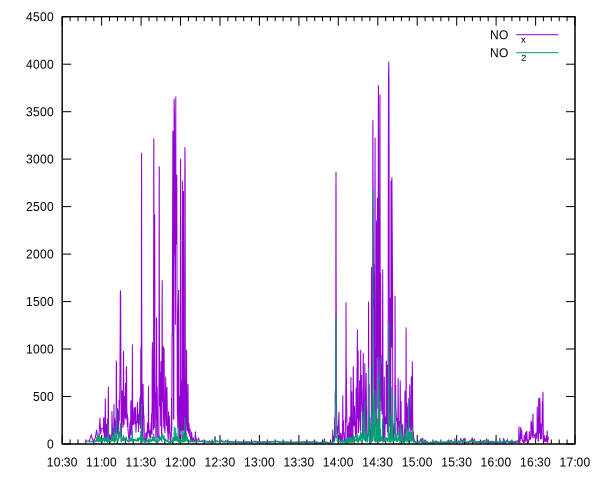

In [13]:
all.index = DateTimeIndex.new(all[:timestamp])

plot = Plot.new(
  [all[:nox], title: "NO_x", with: "lines"],
  [all[:no2], title: "NO_2", with: "lines"],
  format_x: "%H:%M",
  )

## NO computation

For each nox-data-point we look up the next no2 data-point before and afterward, linearly interpolate and subtract the result from nox. What remains is our estimate of the no concentration.

The result ends up in a :no column. So far no error propagation implemented.

In [ ]:
start = DateTime.now
puts "Start NO computation."

all.index = Index.new((0..(all.nrows - 1)).to_a)
all[:index] = all.index.to_a

all[:no] = all.where(all[:no2].eq(nil)).collect_row_with_index do |row,i|
  
  ret = nil
  
  compute = true
  
  if i == 0
    compute = false
  else
    tmp2 = all.row[0..i]
    tmp = tmp2.where(tmp2[:nox].eq(nil))
    
    if tmp.nrows == 0
      compute = false
    else
      l = tmp[:index].to_a.last
    end
  end
 
  if i == all.nrows - 1
    compute = false
  else
    tmp2 = all.row[i..(all.nrows - 1)]
    tmp = tmp2.where(tmp2[:nox].eq(nil))
    
    if tmp.nrows == 0
      compute = false
    else
      u = tmp[:index].to_a.first
    end
  end
    
  if compute
    dy = all[:no2][u] - all[:no2][l]
    dx = (all[:timestamp][u] - all[:timestamp][l]).to_f
    del = (all[:timestamp][i] - all[:timestamp][l]).to_f
 
    ret = all[:nox][i] - (dy/dx*del + all[:no2][l])
  end

  ret
end

stop = DateTime.now

delta = (stop - start).to_f*24*60

puts "NO computation complete. It took #{delta} minutes."

all.head

## More Plots

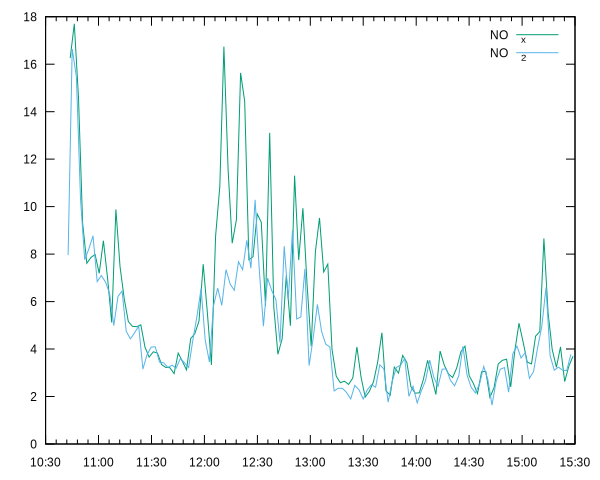

In [32]:
plot << [all[:no], with: "lines", title: "NO"]

## Save NO

In [33]:
all.write_csv(output)
all.head

,index,timestamp,no2,no2_err,o3,o3_err,h2o,h2o_err,nox,nox_err,no
0,0,2016-02-22T10:42:44+01:00,7.95658889551521,0.0653100505114418,35.5115197644284,1149.0426000682,3665141.91075972,925594.721589852,,,
1,1,2016-02-22T10:43:55+01:00,,,2882.62884809316,1866.32015106246,3903930.77976969,1503851.60074163,16.2566628142127,0.107415206400888,3.9590544192544943
2,2,2016-02-22T10:45:06+01:00,16.6386278944012,0.106270597308685,-928.749504463599,1845.33478910489,4366542.36753126,1486963.22039045,,,
3,3,2016-02-22T10:46:16+01:00,,,2587.18198061541,1979.87702335278,4272829.70240693,1595428.677505,17.7000032436948,0.114207158635106,1.640772118722932
4,4,2016-02-22T10:47:27+01:00,15.4715572588364,0.101923822698394,-577.403950806126,1773.10058674671,4241770.73354746,1428662.5383808,,,
5,5,2016-02-22T10:48:38+01:00,,,2438.65996647698,1736.17221507061,3828249.81785127,1398915.48322694,14.5806201843574,0.0996676260001644,1.694475971827469
6,6,2016-02-22T10:49:48+01:00,10.3371454344813,0.0763960025413429,-530.046244473469,1339.39057402859,4082024.36935253,1079010.93990976,,,
7,7,2016-02-22T10:50:59+01:00,,,2828.66443510416,1303.36096429051,3642236.38805852,1049970.59091174,9.31928458200006,0.074230481187959,0.27763876548465305
8,8,2016-02-22T10:52:09+01:00,7.76439267204199,0.0668392742041499,-557.083679993495,1176.23377661221,3313757.52455168,947529.411157991,,,
9,9,2016-02-22T10:53:20+01:00,,,2541.13329136179,1124.5537823362,3716648.02787163,905867.763635704,7.61290572865782,0.0638867897065253,-0.38115356718257054
